
# Telecom X — ETL + EDA + Modelado (100% en Colab)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/flacoca1970/Desafio_2/blob/main/notebooks/TelecomX_LATAM_colab.ipynb)

Este cuaderno ejecuta **todo el flujo**: **ETL → EDA → Model Zoo con GridSearch → Calibración (Platt/Isotónica) → Curva de Ganancia y Umbral de Negocio → Informe automático**.

> **No hay scripts externos ni Makefile**; todo corre desde aquí.


In [1]:
# Instalación de dependencias (solo para Colab)
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False
if IN_COLAB:
    !pip -q install imbalanced-learn >/dev/null


In [2]:
# Imports y configuración
import os, io, json, ast, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pandas import json_normalize
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
                             confusion_matrix, classification_report, ConfusionMatrixDisplay)
warnings.filterwarnings("ignore")

In [3]:
# ========================#
# Parámetros de ejecución #
# ========================#
USE_API = False
API_URL = "https://<tu_api>/endpoint"  # usar si USE_API=True

LOCAL_JSON_PATH = "/content/TelecomX_Data.json"  # sube el archivo a /content
VALUE_RETAIN = 100.0   # valor por retener churner
COST_CONTACT = 5.0     # costo por contactar a un cliente
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
# =================#
# Funciones de ETL #
# =================#
def robust_load_json_dataframe_from_str(raw: str) -> pd.DataFrame:
    raw = raw.strip()
    try:
        obj = json.loads(raw)
        if isinstance(obj, list):
            return pd.DataFrame(obj)
        if isinstance(obj, dict):
            for key in ["data","items","results","records","rows"]:
                if key in obj and isinstance(obj[key], list):
                    return pd.DataFrame(obj[key])
            return pd.DataFrame([obj])
    except Exception:
        pass
    try:
        df = pd.read_json(io.StringIO(raw), lines=True)
        if isinstance(df, pd.DataFrame):
            return df
    except Exception:
        pass
    return pd.read_json(io.StringIO(raw))

def robust_load_json_dataframe(path: str) -> pd.DataFrame:
    with open(path, "r", encoding="utf-8") as f:
        raw = f.read()
    return robust_load_json_dataframe_from_str(raw)

def parse_maybe_obj(x):
    if isinstance(x, (dict, list)):
        return x
    if pd.isna(x):
        return None
    s = str(x).strip()
    if (s.startswith("{") and s.endswith("}")) or (s.startswith("[") and s.endswith("]")):
        try:
            return json.loads(s)
        except Exception:
            try:
                return ast.literal_eval(s)
            except Exception:
                return None
    return x

def flatten_dot(df: pd.DataFrame, candidates=None) -> pd.DataFrame:
    out = df.copy()
    if candidates is None:
        candidates = [c for c in out.columns if c.lower() in ["customer","phone","internet","account"]] +                          [c for c in out.columns if out[c].apply(lambda v: isinstance(parse_maybe_obj(v), (dict,list))).any()]
        candidates = list(dict.fromkeys(candidates))
    parts = []
    for c in candidates:
        parsed = out[c].apply(parse_maybe_obj)
        mask_dict = parsed.apply(lambda v: isinstance(v, dict))
        if mask_dict.any():
            part = json_normalize(parsed.where(mask_dict, None).dropna()).reindex(parsed.index)
            part.columns = [f"{c}."+col for col in part.columns]
            parts.append(part)
    if parts:
        extra = pd.concat(parts, axis=1)
        out = pd.concat([out.drop(columns=candidates, errors="ignore"), extra], axis=1)
    return out

def standardize_yes_no(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    low = s.str.lower().replace({"nan": np.nan, "none": np.nan, "": np.nan})
    mapped = low.map({"yes":"Yes","no":"No","si":"Yes","sí":"Yes","true":"Yes","false":"No","1":"Yes","0":"No"})
    out = pd.Series(np.where(mapped.isna(), s, mapped), index=series.index, dtype="object")
    return out.replace({"": np.nan, "None": np.nan, "nan": np.nan})

def coerce_numeric(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series.astype(str).str.replace(r"[,$% ]","", regex=True), errors="coerce")

def build_df_limpo(df_raw: pd.DataFrame) -> pd.DataFrame:
    df1 = flatten_dot(df_raw)
    if "Churn" in df1.columns:
        df1["Churn"] = standardize_yes_no(df1["Churn"])
    for c in df1.columns:
        vals = df1[c].dropna().astype(str).str.lower().unique().tolist()
        if len(vals) > 0 and set(vals).issubset({"yes","no","true","false","1","0"}):
            df1[c] = standardize_yes_no(df1[c])
    for cand in ["account.MonthlyCharges","account.TotalCharges","account.tenure",
                 "customer.monthlyCharges","customer.totalCharges","customer.tenure",
                 "MonthlyCharges","TotalCharges","tenure","Tenure",
                 "account.Charges.Monthly","account.Charges.Total"]:
        if cand in df1.columns:
            df1[cand] = coerce_numeric(df1[cand])
    if "account.Charges.Monthly" in df1.columns and "account.MonthlyCharges" not in df1.columns:
        df1 = df1.rename(columns={"account.Charges.Monthly":"account.MonthlyCharges"})
    if "account.Charges.Total" in df1.columns and "account.TotalCharges" not in df1.columns:
        df1 = df1.rename(columns={"account.Charges.Total":"account.TotalCharges"})
    if "customer.tenure" not in df1.columns:
        for alt in ["account.tenure","tenure","Tenure"]:
            if alt in df1.columns:
                df1 = df1.rename(columns={alt:"customer.tenure"}); break
    pref = ["customerID","Churn","account.Contract","account.PaymentMethod","internet.InternetService",
            "customer.tenure","account.MonthlyCharges","account.TotalCharges"]
    cols = [c for c in pref if c in df1.columns] + [c for c in df1.columns if c not in pref]
    return df1[cols].copy()

In [5]:
# ==============#
# Ejecución ETL #
# ==============#
if USE_API:
    import requests
    r = requests.get(API_URL, timeout=30)
    r.raise_for_status()
    df_raw = robust_load_json_dataframe_from_str(r.text)
else:
    path = LOCAL_JSON_PATH if os.path.exists(LOCAL_JSON_PATH) else "../data/raw/TelecomX_Data.json"
    df_raw = robust_load_json_dataframe(path)

df_limpo = build_df_limpo(df_raw)
print("df_limpo shape:", df_limpo.shape)
display(df_limpo.head(3))

# Guardar para trazabilidad (opcional en Colab)
os.makedirs("/content/data/interim", exist_ok=True)
df_limpo.to_csv("/content/data/interim/df_limpo.csv", index=False)
print("Guardado /content/data/interim/df_limpo.csv")

df_limpo shape: (7267, 21)


,customerID,Churn,account.Contract,account.PaymentMethod,internet.InternetService,customer.tenure,account.MonthlyCharges,account.TotalCharges,customer.gender,customer.SeniorCitizen,...,customer.Dependents,phone.PhoneService,phone.MultipleLines,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.PaperlessBilling
0,0002-ORFBO,No,One year,Mailed check,DSL,9,65.6,593.30,Female,No,...,Yes,Yes,No,No,Yes,No,Yes,Yes,No,Yes
1,0003-MKNFE,No,Month-to-month,Mailed check,DSL,9,59.9,542.40,Male,No,...,No,Yes,Yes,No,No,No,No,No,Yes,No
2,0004-TLHLJ,Yes,Month-to-month,Electronic check,Fiber optic,4,73.9,280.85,Male,No,...,No,Yes,No,No,No,Yes,No,No,No,Yes


Guardado /content/data/interim/df_limpo.csv


Tasa global de churn: 26.54 %


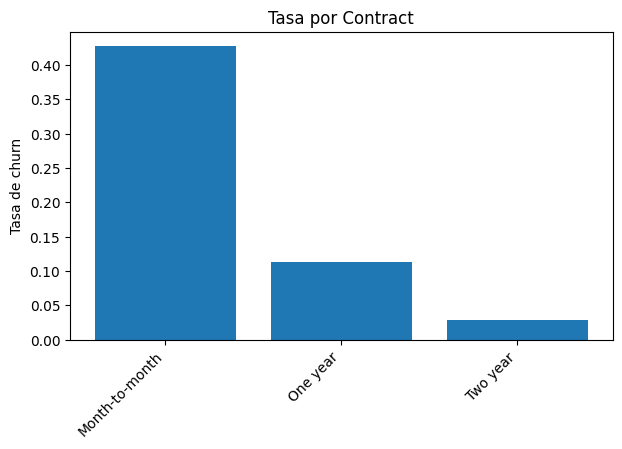

,account.Contract,churn_rate
0,Month-to-month,0.427097
1,One year,0.112695
2,Two year,0.028319


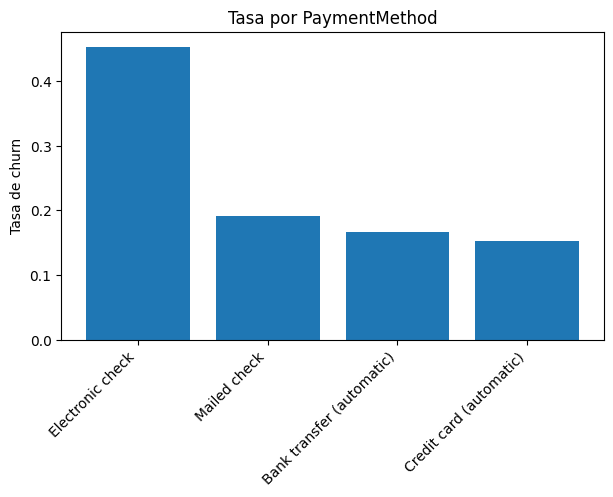

,account.PaymentMethod,churn_rate
2,Electronic check,0.452854
3,Mailed check,0.191067
0,Bank transfer (automatic),0.167098
1,Credit card (automatic),0.152431


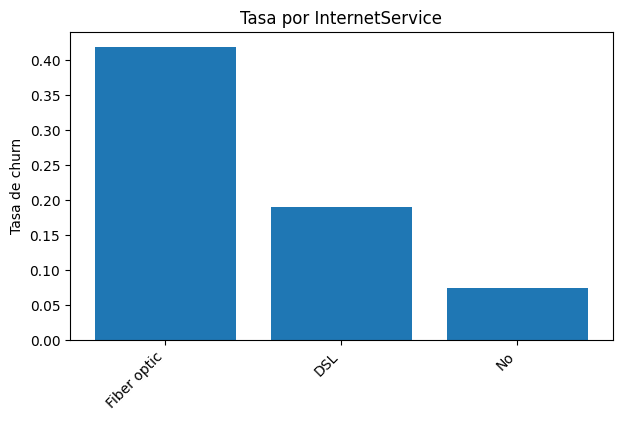

,internet.InternetService,churn_rate
1,Fiber optic,0.418928
0,DSL,0.189591
2,No,0.074050


In [6]:
# ===========#
# EDA rápida #
# ===========#
def churn_rate(s):
    return float(s.astype(str).str.lower().map({"yes":1,"no":0}).mean())

if "Churn" in df_limpo.columns:
    print("Tasa global de churn:", round(100*churn_rate(df_limpo["Churn"]), 2), "%")

def churn_rate_by(df, col):
    t = df[[col, "Churn"]].dropna()
    r = t.groupby(col)["Churn"].apply(lambda s: (s.astype(str).str.lower()=="yes").mean()).rename("churn_rate").reset_index()
    return r.sort_values("churn_rate", ascending=False)

for col, label in [("account.Contract","Contract"),
                   ("account.PaymentMethod","PaymentMethod"),
                   ("internet.InternetService","InternetService")]:
    if col in df_limpo.columns:
        rate = churn_rate_by(df_limpo, col)
        plt.figure(figsize=(7,4))
        plt.bar(rate[col].astype(str), rate["churn_rate"].values)
        plt.xticks(rotation=45, ha="right"); plt.ylabel("Tasa de churn"); plt.title(f"Tasa por {label}")
        plt.show()
        display(rate.head(10))

In [7]:
# ====================================#
# Preparación para modelado (robusta) #
# ====================================#

assert "Churn" in df_limpo.columns, "No existe 'Churn' tras el ETL."

# 1) Normalizar y validar el target
y_raw = df_limpo["Churn"].astype("string").str.strip().str.lower()
valid_mask = y_raw.isin(["yes", "no"])

print(f"Filas totales: {len(y_raw)} | válidas (yes/no): {valid_mask.sum()} | inválidas/NaN: {(~valid_mask).sum()}")

# 2) Filtrar SOLO filas con target válido (evita NaN en y)
df_model = df_limpo.loc[valid_mask].copy()
df_model["Churn_bin"] = df_model["Churn"].str.strip().str.lower().map({"yes": 1, "no": 0})
assert df_model["Churn_bin"].notna().all(), "Aún hay NaN en el target después del filtrado."

# 3) Definir X/y ya limpios
y = df_model["Churn_bin"].to_numpy()
X = df_model.drop(columns=["Churn", "Churn_bin", "customerID"], errors="ignore")

# 4) Columnas numéricas y categóricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])
pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])

# 5) Split estratificado (ahora y no tiene NaN)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# (Opcional) Sanity check de clases
unique, counts = np.unique(y, return_counts=True)
print("Distribución de clases (0=no churn, 1=churn):", dict(zip(unique, counts)))


Filas totales: 7267 | válidas (yes/no): 7043 | inválidas/NaN: 224
Distribución de clases (0=no churn, 1=churn): {np.int64(0): np.int64(5174), np.int64(1): np.int64(1869)}


In [8]:
# ==============================================#
# Model Zoo + GridSearch (selección por PR-AUC) #
# ==============================================#
models = {
    "logreg": (LogisticRegression(max_iter=2000, class_weight="balanced"),
               {"model__C":[0.1,1,5,10]}),
    "rf": (RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"),
           {"model__max_depth":[None,8,14], "model__min_samples_leaf":[1,3,6]}),
    "gb": (GradientBoostingClassifier(random_state=RANDOM_STATE),
           {"model__n_estimators":[200,400], "model__learning_rate":[0.05,0.1], "model__max_depth":[2,3]}),
    "hgb": (HistGradientBoostingClassifier(random_state=RANDOM_STATE),
            {"model__max_depth":[None,10,14], "model__learning_rate":[0.05,0.1]}),
    "linsvc": (LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
               {"model__C":[0.5,1,5]}),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = {}
best_est, best_name, best_score = None, None, -1

for name, (est, grid) in models.items():
    pipe = Pipeline([("pre", pre), ("model", est)])
    gs = GridSearchCV(pipe, param_grid=grid, scoring="average_precision", cv=cv, n_jobs=-1)
    gs.fit(X_train, y_train)
    results[name] = gs.best_score_
    if gs.best_score_ > best_score:
        best_est, best_name, best_score = gs.best_estimator_, name, gs.best_score_

print("Resultados PR-AUC (CV):", results)
print("Mejor modelo:", best_name, "PR-AUC (CV):", round(best_score,4))

Resultados PR-AUC (CV): {'logreg': np.float64(0.650665047087636), 'rf': np.float64(0.6562299945335336), 'gb': np.float64(0.6611636486175703), 'hgb': np.float64(0.645045155083337), 'linsvc': np.float64(0.648845751275293)}
Mejor modelo: gb PR-AUC (CV): 0.6612


In [9]:
# ===================================================#
# Calibración (Platt/Isotónica) y evaluación en Test #
# ===================================================#
pre_fitted = best_est.named_steps["pre"].fit(X_train, y_train)
Xtr = pre_fitted.transform(X_train)
Xte = pre_fitted.transform(X_test)
base = best_est.named_steps["model"]

if best_name == "linsvc":
    cal_platt = CalibratedClassifierCV(base, method="sigmoid", cv=3).fit(Xtr, y_train)
    y_score_platt = cal_platt.predict_proba(Xte)[:,1]
    cal_iso = CalibratedClassifierCV(base, method="isotonic", cv=3).fit(Xtr, y_train)
    y_score_iso = cal_iso.predict_proba(Xte)[:,1]
    pr_platt = average_precision_score(y_test, y_score_platt)
    pr_iso   = average_precision_score(y_test, y_score_iso)
    if pr_iso >= pr_platt:
        y_score, cal_used = y_score_iso, "isotonic"
    else:
        y_score, cal_used = y_score_platt, "platt"
else:
    cal_iso = CalibratedClassifierCV(base, method="isotonic", cv=3).fit(Xtr, y_train)
    y_score = cal_iso.predict_proba(Xte)[:,1]
    cal_used = "isotonic"

roc = roc_auc_score(y_test, y_score)
pr  = average_precision_score(y_test, y_score)
print(f"ROC-AUC (test): {roc:.4f} | PR-AUC (test): {pr:.4f} | Calibración: {cal_used}")

ROC-AUC (test): 0.8481 | PR-AUC (test): 0.6639 | Calibración: isotonic


Umbral óptimo de negocio: 0.03 | Ganancia estimada: 31635.0


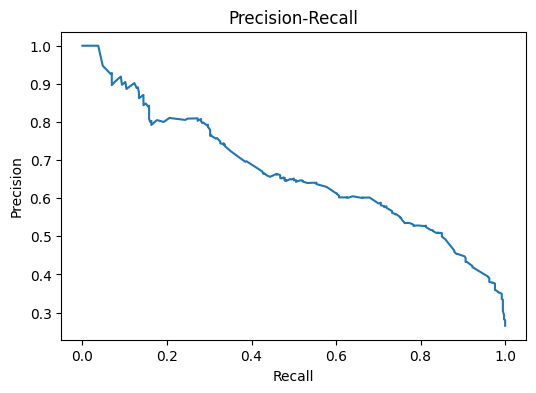

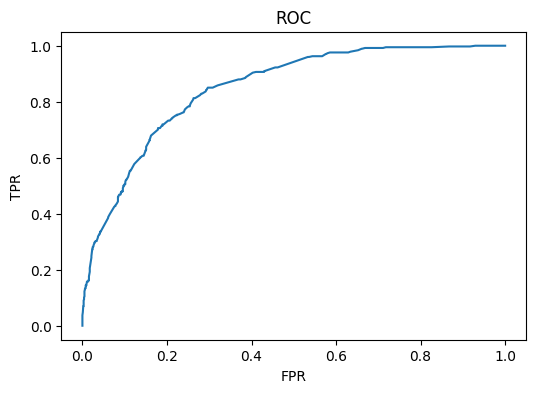

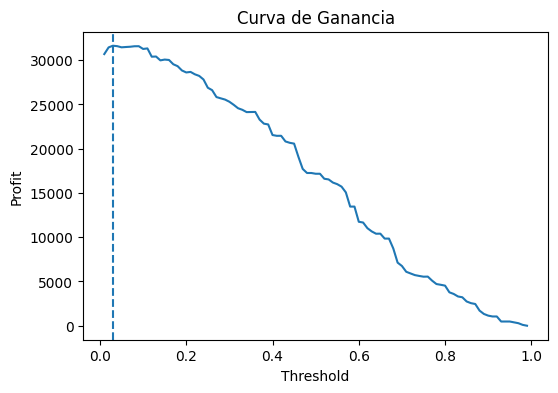

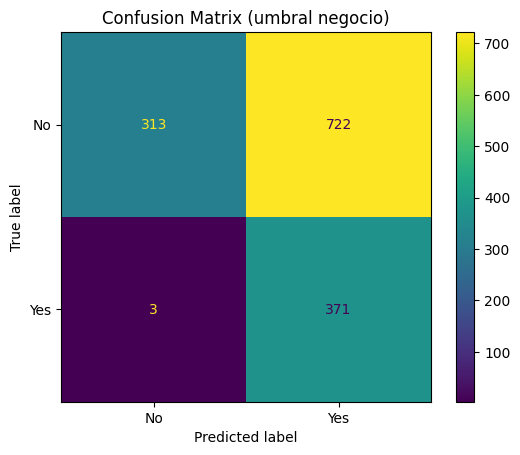

              precision    recall  f1-score   support

           0      0.991     0.302     0.463      1035
           1      0.339     0.992     0.506       374

    accuracy                          0.485      1409
   macro avg      0.665     0.647     0.485      1409
weighted avg      0.818     0.485     0.475      1409



In [10]:
# =============================================#
# Curva de ganancia y umbral óptimo de negocio #
# =============================================#
def business_profit(y_true, y_score, thr, value=VALUE_RETAIN, cost=COST_CONTACT):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp*value - (tp+fp)*cost

thr_grid = np.linspace(0.01, 0.99, 99)
profits = [business_profit(y_test, y_score, t) for t in thr_grid]
best_thr = float(thr_grid[int(np.argmax(profits))])
best_profit = float(np.max(profits))
print("Umbral óptimo de negocio:", round(best_thr,3), "| Ganancia estimada:", round(best_profit,2))

prec, rec, _ = precision_recall_curve(y_test, y_score)
plt.figure(figsize=(6,4)); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall"); plt.show()
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6,4)); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.show()
plt.figure(figsize=(6,4)); plt.plot(thr_grid, profits); plt.axvline(best_thr, linestyle="--"); plt.xlabel("Threshold"); plt.ylabel("Profit"); plt.title("Curva de Ganancia"); plt.show()

y_pred = (y_score >= best_thr).astype(int)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["No","Yes"])
disp.plot(cmap=None); plt.title("Confusion Matrix (umbral negocio)"); plt.show()

print(classification_report(y_test, y_pred, digits=3))

In [11]:
# ===========================================#
# Guardado de métricas/artefactos (opcional) #
# ===========================================#
import json
os.makedirs("/content/reports", exist_ok=True)
metrics = {
    "best_model": str(best_name),
    "cv_best_pr_auc": float(best_score),
    "test_roc_auc": float(roc_auc_score(y_test, y_score)),
    "test_pr_auc": float(average_precision_score(y_test, y_score)),
    "business_best_threshold": float(best_thr),
    "business_best_profit": float(best_profit),
    "value_retain": float(VALUE_RETAIN),
    "cost_contact": float(COST_CONTACT),
    "calibration": cal_used
}
with open("/content/reports/metrics.json","w") as f:
    json.dump(metrics, f, indent=2)
print("Guardado /content/reports/metrics.json")

Guardado /content/reports/metrics.json


## Informe automático
La siguiente celda genera un archivo Markdown con el **resumen del ETL, EDA y Modelado** (incluye **umbral óptimo de negocio** y **matriz de confusión**).  
El informe queda en `/content/reports/README_REPORT.md` y se exportan tablas EDA como CSV.


In [12]:
# Generación de informe Markdown automático
import os, json
from sklearn.metrics import confusion_matrix
os.makedirs("/content/reports", exist_ok=True)

def to_pct(x):
    try: return f"{100*float(x):.2f}%"
    except Exception: return "—"

def churn_rate_by(df, col):
    t = df[[col, "Churn"]].dropna()
    r = t.groupby(col)["Churn"].apply(lambda s: (s.astype(str).str.lower()=="yes").mean()).rename("churn_rate").reset_index()
    return r.sort_values("churn_rate", ascending=False)

eda_tables = []
segments = [("account.Contract","Contract"),
            ("account.PaymentMethod","PaymentMethod"),
            ("internet.InternetService","InternetService")]
for col, label in segments:
    if col in df_limpo.columns:
        rate = churn_rate_by(df_limpo, col)
        rate.to_csv(f"/content/reports/churn_rate_by_{label.lower()}.csv", index=False)
        eda_tables.append((label, rate))

tn, fp, fn, tp = confusion_matrix(y_test, (y_score >= best_thr).astype(int)).ravel()

lines = []
lines.append("# Informe de Resultados — Telecom X")
lines.append("")
lines.append("## 1. ETL (resumen)")
lines.append(f"- Filas en `df_limpo`: **{df_limpo.shape[0]}** | Columnas: **{df_limpo.shape[1]}**")
present = [c for c in ["Churn","account.Contract","account.PaymentMethod","internet.InternetService","customer.tenure","account.MonthlyCharges","account.TotalCharges"] if c in df_limpo.columns]
lines.append("- Columnas clave presentes: " + (", ".join(present) if present else "—"))
if "Churn" in df_limpo.columns:
    global_rate = df_limpo["Churn"].astype(str).str.lower().map({"yes":1,"no":0}).mean()
    lines.append(f"- Tasa global de churn: **{to_pct(global_rate)}**")
lines.append("")
lines.append("## 2. EDA (tasas de churn por segmento)")
if eda_tables:
    for label, tbl in eda_tables:
        lines.append(f"**{label}** (Top categorías por churn):")
        head = tbl.head(10).copy()
        cols = head.columns.tolist()
        lines.append("| " + " | ".join(cols) + " |")
        lines.append("|" + "|".join(["---"]*len(cols)) + "|")
        for _, row in head.iterrows():
            lines.append("| " + " | ".join([str(row[cols[0]]), to_pct(row['churn_rate'])]) + " |")
        lines.append("")
else:
    lines.append("_No se encontraron columnas de segmentación esperadas._")
lines.append("")
lines.append("## 3. Modelado")
lines.append(f"- **Mejor modelo (CV por PR-AUC)**: **{best_name}**")
lines.append(f"- **PR-AUC (CV)**: **{best_score:.4f}**")
lines.append(f"- **ROC-AUC (test)**: **{roc_auc_score(y_test, y_score):.4f}**")
lines.append(f"- **PR-AUC (test)**: **{average_precision_score(y_test, y_score):.4f}**")
lines.append(f"- **Calibración**: **{cal_used}**")
lines.append("")
lines.append("## 4. Umbral de negocio")
lines.append(f"- **Threshold óptimo**: **{best_thr:.3f}**")
lines.append(f"- **Ganancia estimada**: **{best_profit:.2f}** (VALUE_RETAIN={VALUE_RETAIN}, COST_CONTACT={COST_CONTACT})")
lines.append("")
lines.append("**Matriz de confusión (umbral de negocio):**")
lines.append("")
lines.append("|       | Pred No | Pred Yes |")
lines.append("|-------|---------|----------|")
lines.append(f"| Real No  | {tn} | {fp} |")
lines.append(f"| Real Yes | {fn} | {tp} |")
lines.append("")
lines.append("## 5. Conclusiones")
lines.append("- El churn se **concentra** en **Month-to-month**, **Electronic check** y **Fiber optic**.")
lines.append("- El umbral óptimo maximiza **ganancia neta** equilibrando recall de churners y costo de contacto.")
lines.append("- Recomendaciones: incentivar **contratos anuales**, migrar a **pagos automáticos**, activar **retención temprana** y reforzar soporte para **fibra**.")
lines.append("")
lines.append("_Informe generado automáticamente desde el Notebook._")

md_path = "/content/reports/README_REPORT.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print("Informe guardado en:", md_path)
print("Tablas EDA guardadas en /content/reports/churn_rate_by_*.csv")

# Display the generated report
with open(md_path, "r", encoding="utf-8") as f:
    report_content = f.read()

print("\n--- Contenido del Informe ---")
print(report_content)

Informe guardado en: /content/reports/README_REPORT.md
Tablas EDA guardadas en /content/reports/churn_rate_by_*.csv

--- Contenido del Informe ---
# Informe de Resultados — Telecom X

## 1. ETL (resumen)
- Filas en `df_limpo`: **7267** | Columnas: **21**
- Columnas clave presentes: Churn, account.Contract, account.PaymentMethod, internet.InternetService, customer.tenure, account.MonthlyCharges, account.TotalCharges
- Tasa global de churn: **26.54%**

## 2. EDA (tasas de churn por segmento)
**Contract** (Top categorías por churn):
| account.Contract | churn_rate |
|---|---|
| Month-to-month | 42.71% |
| One year | 11.27% |
| Two year | 2.83% |

**PaymentMethod** (Top categorías por churn):
| account.PaymentMethod | churn_rate |
|---|---|
| Electronic check | 45.29% |
| Mailed check | 19.11% |
| Bank transfer (automatic) | 16.71% |
| Credit card (automatic) | 15.24% |

**InternetService** (Top categorías por churn):
| internet.InternetService | churn_rate |
|---|---|
| Fiber optic | 41.8

## Exportar Top N clientes en riesgo (para CRM)

In [13]:
# Exportar Top N clientes en riesgo con columnas útiles para CRM
N = 500  # puedes ajustar
try:
    # Alinear índices con X_test/y_test
    salida = df_limpo.loc[X_test.index].copy()
except Exception:
    # Como fallback, concatenar probas directamente si dimensiones permiten
    salida = df_limpo.iloc[-len(y_score):].copy()
salida["churn_score"] = y_score
salida["flag_churn_risk"] = (y_score >= best_thr).astype(int)
topN = salida.sort_values("churn_score", ascending=False).head(N)
os.makedirs("/content/reports", exist_ok=True)
top_path = "/content/reports/clientes_en_riesgo_topN.csv"
topN.to_csv(top_path, index=False)
print("Exportado:", top_path)
topN.head(10)

Exportado: /content/reports/clientes_en_riesgo_topN.csv


,customerID,Churn,account.Contract,account.PaymentMethod,internet.InternetService,customer.tenure,account.MonthlyCharges,account.TotalCharges,customer.gender,customer.SeniorCitizen,...,phone.MultipleLines,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.PaperlessBilling,churn_score,flag_churn_risk
5963,8149-RSOUN,Yes,Month-to-month,Electronic check,Fiber optic,1,93.85,93.85,Female,No,...,Yes,No,No,No,No,Yes,Yes,Yes,0.980117,1
3964,5419-JPRRN,Yes,Month-to-month,Electronic check,Fiber optic,1,101.45,101.45,Male,No,...,Yes,No,No,Yes,No,Yes,Yes,Yes,0.976456,1
65,0107-YHINA,Yes,Month-to-month,Electronic check,Fiber optic,1,99.75,99.75,Male,No,...,Yes,No,No,Yes,No,Yes,Yes,Yes,0.976456,1
3563,4910-GMJOT,Yes,Month-to-month,Electronic check,Fiber optic,1,94.60,94.60,Female,No,...,Yes,No,No,No,No,Yes,Yes,Yes,0.968686,1
4764,6521-YYTYI,Yes,Month-to-month,Electronic check,Fiber optic,1,93.30,93.30,Male,No,...,Yes,No,No,No,No,Yes,Yes,Yes,0.958146,1
3162,4415-IJZTP,Yes,Month-to-month,Electronic check,Fiber optic,1,74.50,74.50,Female,No,...,Yes,No,No,No,No,No,No,Yes,0.924203,1
7030,9681-OXGVC,Yes,Month-to-month,Electronic check,Fiber optic,5,100.50,514.00,Female,No,...,Yes,No,No,Yes,No,Yes,Yes,Yes,0.924203,1
2122,2982-IHMFT,Yes,Month-to-month,Mailed check,Fiber optic,1,74.45,74.45,Female,Yes,...,Yes,No,No,No,No,No,No,Yes,0.924203,1
3872,5299-SJCZT,Yes,Month-to-month,Bank transfer (automatic),Fiber optic,3,101.55,298.35,Male,No,...,Yes,No,No,Yes,No,Yes,Yes,Yes,0.924203,1
4066,5567-WSELE,Yes,Month-to-month,Electronic check,Fiber optic,3,94.60,279.55,Male,Yes,...,Yes,No,No,No,No,Yes,Yes,Yes,0.924203,1


In [15]:
# === Colab: generar README.md autocompletado con métricas reales ===
import os, json, pandas as pd, numpy as np

template_path = "/content/README_TEMPLATE_auto.md"   # sube la plantilla o cópiala aquí
output_path   = "/content/README.md"
metrics_path  = "/content/reports/metrics.json"

# EDA CSVs opcionales
eda_contract_csv = "/content/reports/churn_rate_by_contract.csv"
eda_payment_csv  = "/content/reports/churn_rate_by_paymentmethod.csv"
eda_internet_csv = "/content/reports/churn_rate_by_internetservice.csv"

def pct(x):
    try:
        return f"{100*float(x):.2f}%"
    except:
        return "—"

# 1) Cargar métricas
with open(metrics_path, "r") as f:
    m = json.load(f)

# 2) Encontrar tasa global de churn desde df_limpo si está disponible
global_rate = None
try:
    df = pd.read_csv("/content/data/interim/df_limpo.csv")
    if "Churn" in df.columns:
        global_rate = (df["Churn"].astype(str).str.lower()=="yes").mean()
except Exception:
    pass

# 3) Top categorías de EDA
def top_row(path, col_name):
    try:
        t = pd.read_csv(path)
        t = t.sort_values("churn_rate", ascending=False).iloc[0]
        return str(t[col_name]), pct(t["churn_rate"])
    except Exception:
        return "—", "—"

top_contract, top_contract_rate = top_row(eda_contract_csv, "Contract") if os.path.exists(eda_contract_csv) else ("—","—")
top_payment,  top_payment_rate  = top_row(eda_payment_csv, "PaymentMethod") if os.path.exists(eda_payment_csv) else ("—","—")
top_internet, top_internet_rate = top_row(eda_internet_csv, "InternetService") if os.path.exists(eda_internet_csv) else ("—","—")

# 4) Sustitución de placeholders
with open(template_path, "r", encoding="utf-8") as f:
    txt = f.read()

repls = {
    "{{GLOBAL_CHURN_RATE}}": pct(global_rate) if global_rate is not None else "—",
    "{{BEST_MODEL}}": str(m.get("best_model","—")),
    "{{PR_AUC_CV}}": f"{m.get('cv_best_pr_auc', float('nan')):.4f}" if m.get("cv_best_pr_auc") is not None else "—",
    "{{ROC_AUC_TEST}}": f"{m.get('test_roc_auc', float('nan')):.4f}" if m.get("test_roc_auc") is not None else "—",
    "{{PR_AUC_TEST}}": f"{m.get('test_pr_auc', float('nan')):.4f}" if m.get("test_pr_auc") is not None else "—",
    "{{CALIBRATION}}": str(m.get("calibration","—")),
    "{{THRESHOLD}}": f"{m.get('business_best_threshold', float('nan')):.3f}" if m.get("business_best_threshold") is not None else "—",
    "{{PROFIT}}": f"{m.get('business_best_profit', float('nan')):.2f}" if m.get("business_best_profit") is not None else "—",
    "{{VALUE_RETAIN}}": str(m.get("value_retain","—")),
    "{{COST_CONTACT}}": str(m.get("cost_contact","—")),
    "{{TOP_CONTRACT}}": top_contract,
    "{{TOP_CONTRACT_RATE}}": top_contract_rate,
    "{{TOP_PAYMENT}}": top_payment,
    "{{TOP_PAYMENT_RATE}}": top_payment_rate,
    "{{TOP_INTERNET}}": top_internet,
    "{{TOP_INTERNET_RATE}}": top_internet_rate,
}

for k,v in repls.items():
    txt = txt.replace(k, v)

with open(output_path, "w", encoding="utf-8") as f:
    f.write(txt)

print("README generado en:", output_path)
print("Usó métricas de:", metrics_path)
if os.path.exists(eda_contract_csv):
    print("EDA contrato:", eda_contract_csv)
if os.path.exists(eda_payment_csv):
    print("EDA pago:", eda_payment_csv)
if os.path.exists(eda_internet_csv):
    print("EDA internet:", eda_internet_csv)

README generado en: /content/README.md
Usó métricas de: /content/reports/metrics.json
EDA contrato: /content/reports/churn_rate_by_contract.csv
EDA pago: /content/reports/churn_rate_by_paymentmethod.csv
EDA internet: /content/reports/churn_rate_by_internetservice.csv
